# Milestone #4 - Baseline Model

In [291]:
import pandas as pd
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer
from sklearn import cross_validation
from sklearn import covariance
import string
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import math
import string
import os
import datetime

#### Import and concatenate all of our data

In [292]:
# concatenate all of our manhattan data into one dataframe
path_to_zillow_data = "Manhattan/"

files = os.listdir(path_to_zillow_data)

raw_dfs = {}
for fname in files:
    raw_dfs[fname] = pd.read_csv(path_to_zillow_data + fname)
    
mn_df = pd.concat([raw_dfs[key] for key in raw_dfs.keys()], ignore_index=True)

mn_df = mn_df.dropna(how='all')

In [293]:
mn_df.head()

,tax_value,last_sold_price,property_size,zestimate_amount,bathrooms,zestimate_valuation_range_high,tax_year,zestimate_value_change,latitude,zestimate_percentile,...,last_sold_date,year_built,zestimate_valuationRange_low,graph_data_link,home_size,longitude,home_detail_link,home_type,map_this_home_link,Unnamed: 22
0,NaN,NaN,NaN,849427.0,1.0,1044795.0,NaN,NaN,40.724448,0.0,...,NaN,NaN,696530.0,NaN,400.0,-73.980284,http://www.zillow.com/homedetails/202-E-7th-St...,MultiFamily2To4,http://www.zillow.com/homes/2098748189_zpid/,NaN
1,1642000.0,NaN,2250.0,NaN,2.0,NaN,2015.0,NaN,40.724420,0.0,...,NaN,1900.0,NaN,http://www.zillow.com/homedetails/204-E-7th-St...,10800.0,-73.980200,http://www.zillow.com/homedetails/204-E-7th-St...,Apartment,http://www.zillow.com/homes/31495862_zpid/,NaN
2,1674000.0,NaN,2250.0,7332356.0,1.0,7992268.0,2015.0,NaN,40.724385,0.0,...,NaN,1900.0,6305826.0,http://www.zillow.com/homedetails/206-E-7th-St...,10800.0,-73.980120,http://www.zillow.com/homedetails/206-E-7th-St...,Cooperative,http://www.zillow.com/homes/31495863_zpid/,NaN
3,NaN,NaN,NaN,1991289.0,1.0,2708153.0,NaN,NaN,40.724332,0.0,...,NaN,NaN,1234599.0,NaN,NaN,-73.980007,http://www.zillow.com/homedetails/208-E-7th-St...,MultiFamily2To4,http://www.zillow.com/homes/2098632095_zpid/,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.724845,0.0,...,NaN,NaN,NaN,NaN,NaN,-73.980804,http://www.zillow.com/homedetails/190-E-7th-St...,Unknown,http://www.zillow.com/homes/2131860614_zpid/,NaN


#### Visualize how different variables affect price

##### Latitude and longitude

In [294]:
zestimate_no_nas = mn_df["zestimate_amount"][np.isfinite(mn_df["zestimate_amount"])]
zestimate_no_nas.quantile([0.25,0.5,0.75])

q1_price = zestimate_no_nas.quantile([0.25, 0.5, 0.75]).values[0]
q2_price = zestimate_no_nas.quantile([0.25, 0.5, 0.75]).values[1]
q3_price = zestimate_no_nas.quantile([0.25, 0.5, 0.75]).values[2]

price_brackets = np.empty(len(mn_df))

for i in range(len(mn_df)):
    if not math.isnan(mn_df["zestimate_amount"][i]):
        if mn_df["zestimate_amount"][i] < q1_price:
            price_brackets[i] = 1
        elif ((mn_df["zestimate_amount"][i] >= q1_price) & (mn_df["zestimate_amount"][i] < q2_price)):
            price_brackets[i] = 2
        elif ((mn_df["zestimate_amount"][i] >= q2_price) & (mn_df["zestimate_amount"][i] < q3_price)):
            price_brackets[i] = 3
        else:
            price_brackets[i] = 4
    
mn_df["price_bracket"] = price_brackets

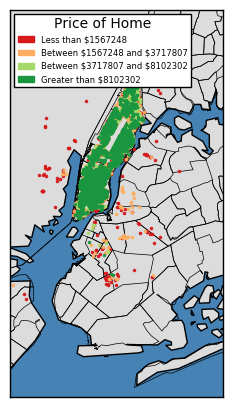

In [295]:
fig = plt.figure(figsize=(10,5))

themap = Basemap(projection='merc',
                llcrnrlon = -74.097444,              # lower-left corner longitude
                llcrnrlat = 40.533572,               # lower-left corner latitude
                urcrnrlon = -73.831712,               # upper-right corner longitude
                urcrnrlat = 40.9,               # upper-right corner latitude
                resolution = 'h',
                area_thresh = 0.1,
              )

themap.drawcoastlines()
themap.drawcountries()
themap.drawstates()
themap.drawrivers()
themap.fillcontinents(color = 'gainsboro')
themap.drawmapboundary(fill_color='steelblue')

themap.readshapefile('./ZillowNeighborhoods-NY/ZillowNeighborhoods-NY', 'regions', drawbounds = True)

color_list = ["#d7191c", "#fdae61", "#a6d96a", "#1a9641"]
bracket_list = range(1,5)
for bracket in bracket_list:
    mn_df_bracket = mn_df[mn_df["price_bracket"] == bracket]
    x, y = themap(mn_df_bracket["longitude"].values, mn_df_bracket["latitude"].values)
    themap.plot(x, y, '.', color=color_list[bracket-1],markersize=4)
    
patch1 = mpatches.Patch(color="#d7191c", label='Less than \$' + str(int(q1_price)))
patch2 = mpatches.Patch(color="#fdae61", label='Between \$' + str(int(q1_price)) + ' and \$' + str(int(q2_price)))
patch3 = mpatches.Patch(color="#a6d96a", label='Between \$' + str(int(q2_price)) + ' and \$' + str(int(q3_price)))
patch4 = mpatches.Patch(color="#1a9641", label='Greater than \$' + str(int(q3_price)))

plt.legend(handles=[patch1, patch2, patch3, patch4], loc = 2, prop={'size':6}, title = "Price of Home")

plt.show()

##### Property size and year built

(1500, 2500)

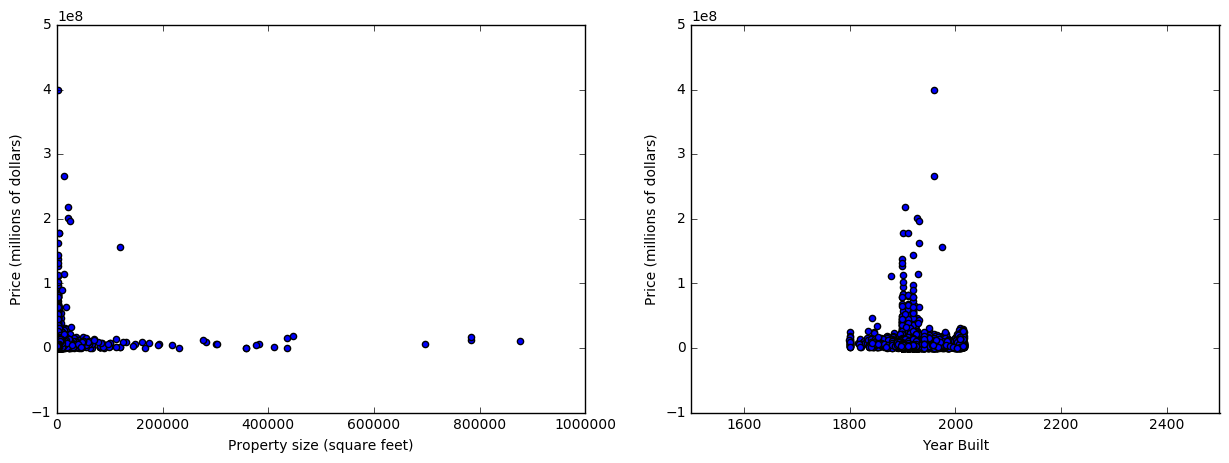

In [306]:
fig, ax = plt.subplots(1,2, figsize = (15,5))

ax[0].scatter(mn_df["property_size"],mn_df["zestimate_amount"])
ax[0].set_xlabel("Property size (square feet)")
ax[0].set_ylabel("Price (millions of dollars)")
ax[0].set_xlim([0,1000000])

ax[1].scatter(mn_df["year_built"], mn_df["zestimate_amount"])
ax[1].set_xlabel("Year Built")
ax[1].set_ylabel("Price (millions of dollars)")
ax[1].set_xlim([1500,2500])

##### Number of bedrooms

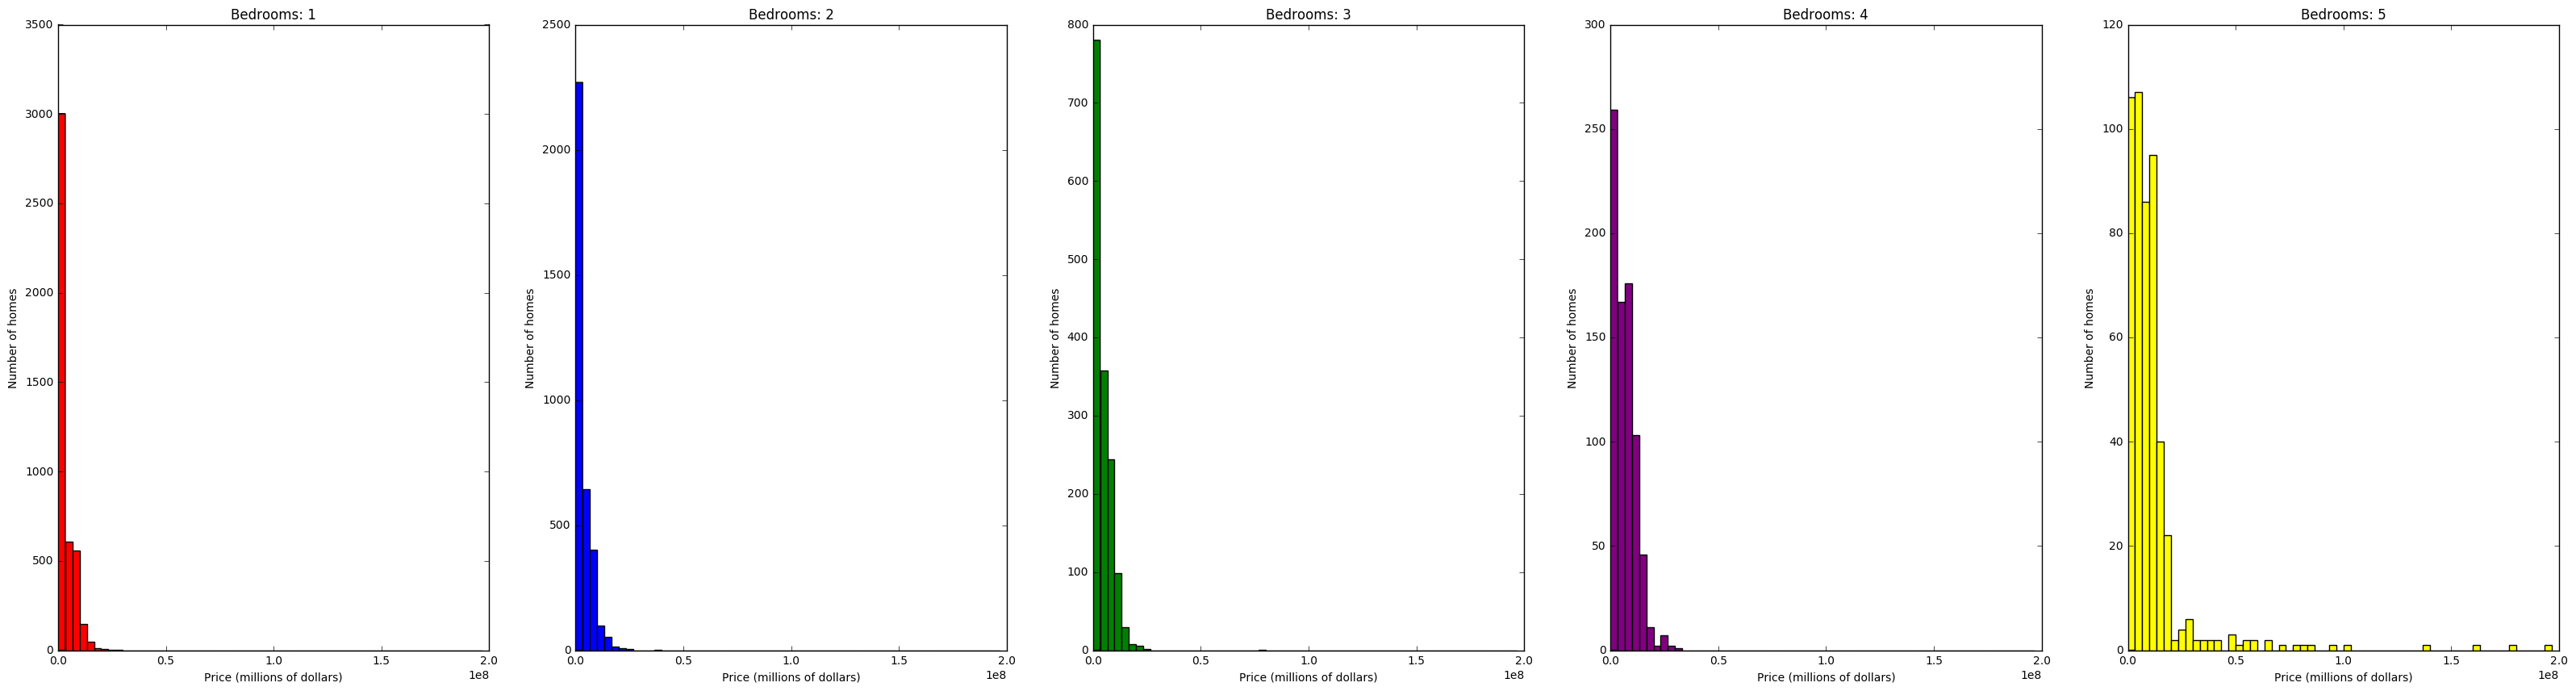

In [308]:
min_price = np.min(mn_df["zestimate_amount"])
max_price = np.max(mn_df["zestimate_amount"])
bins = np.arange(min_price, max_price/2, (min_price + max_price/4) / 30.0) 
        
fig, ax = plt.subplots(1, 5, figsize = (40,10))

for i in range (1,6):
    subset = mn_df[mn_df["bedrooms"] == i]
    subset = subset.dropna(axis = 0, subset = ["zestimate_amount"])
    ax[i-1].hist(subset["zestimate_amount"], bins = bins, range = (0,6000000), color = colors[i-1])
    title = "Bedrooms: " + str(i)
    ax[i-1].set_title(title)
    ax[i-1].set_xlabel("Price (millions of dollars)")
    ax[i-1].set_ylabel("Number of homes")
plt.show() 

##### Number of bathrooms

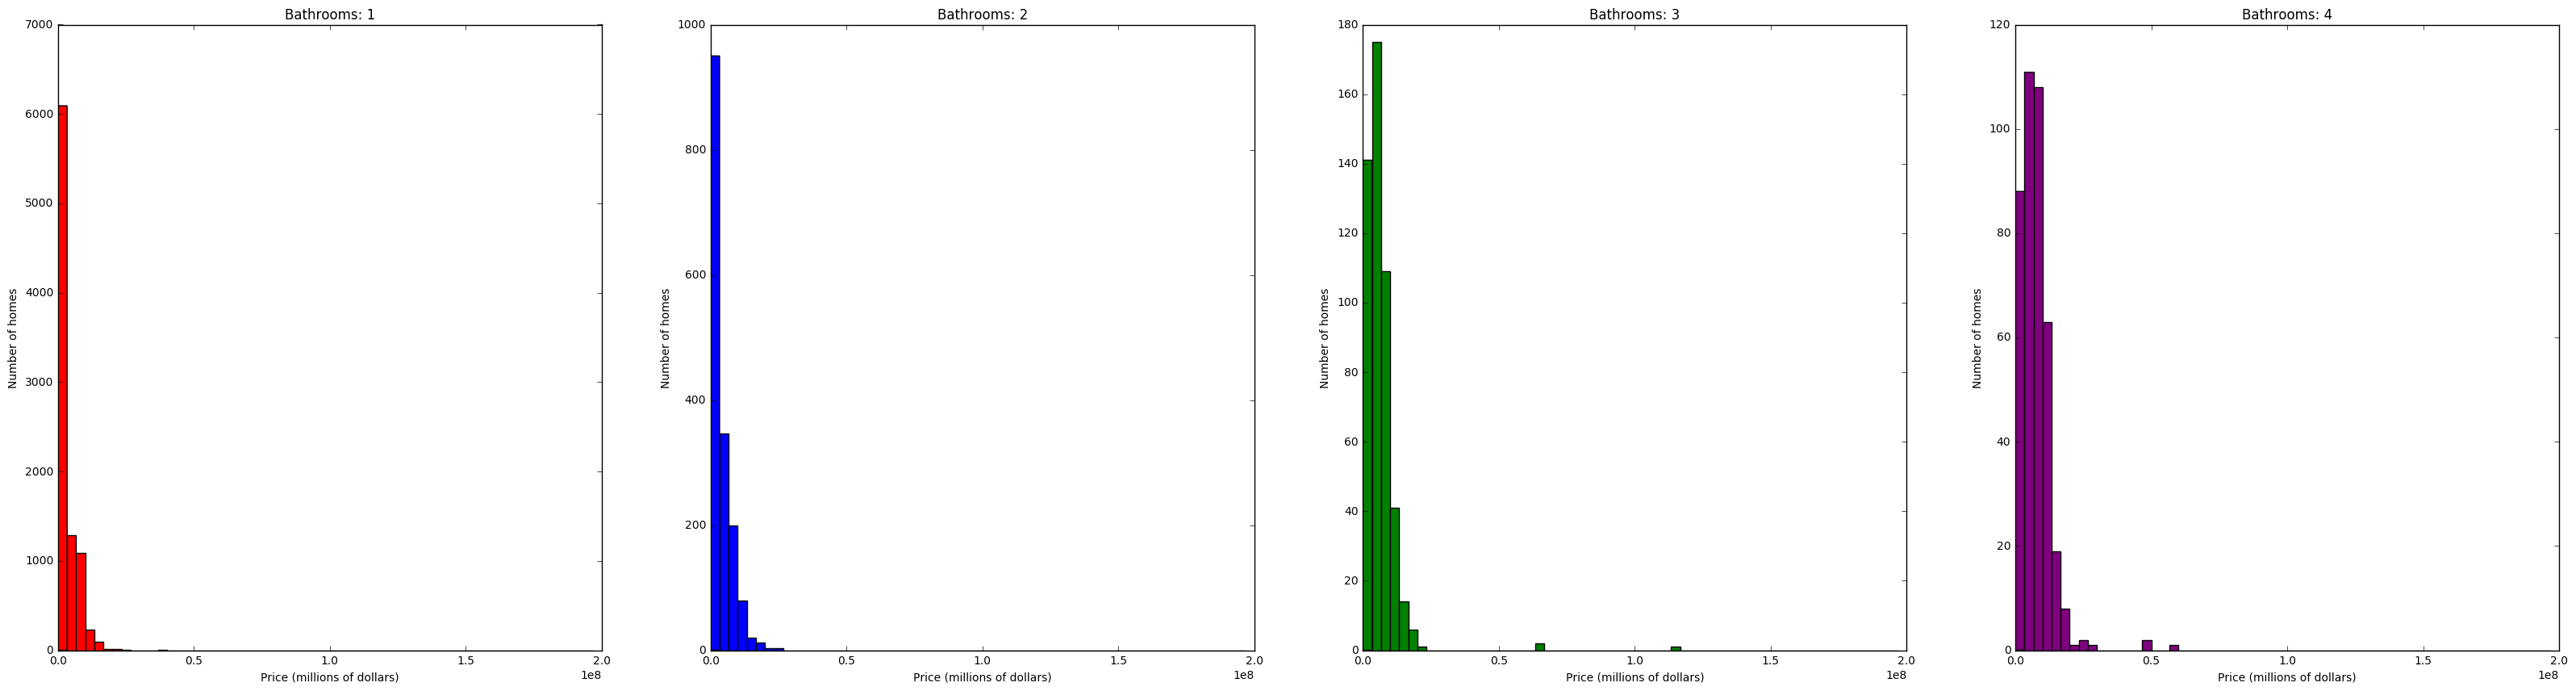

In [307]:
min_price = np.min(mn_df["zestimate_amount"])
max_price = np.max(mn_df["zestimate_amount"])
bins = np.arange(min_price, max_price/2, (min_price + max_price/4) / 30.0) 
        
fig, ax = plt.subplots(1, 4, figsize = (40,10))

colors = ["red", "blue", "green", "purple", "yellow"]

for i in range (1,5):
    subset = mn_df[mn_df["bathrooms"] == i]
    subset = subset.dropna(axis = 0, subset = ["zestimate_amount"])
    ax[i-1].hist(subset["zestimate_amount"], bins = bins, range = (0,6000000), color = colors[i-1])
    title = "Bathrooms: " + str(i)
    ax[i-1].set_title(title)
    ax[i-1].set_xlabel("Price (millions of dollars)")
    ax[i-1].set_ylabel("Number of homes")
plt.show() 

#### Data cleaning

In [296]:
mn_df.columns.values

array(['tax_value', 'last_sold_price', 'property_size', 'zestimate_amount',
       'bathrooms', 'zestimate_valuation_range_high', 'tax_year',
       'zestimate_value_change', 'latitude', 'zestimate_percentile',
       'bedrooms', 'zestimate_last_updated', 'zillow_id', 'last_sold_date',
       'year_built', 'zestimate_valuationRange_low', 'graph_data_link',
       'home_size', 'longitude', 'home_detail_link', 'home_type',
       'map_this_home_link', 'Unnamed: 22', 'price_bracket'], dtype=object)

In [297]:
# get rid of rows that have missing values for our y value (zestimate_amount)
mn_df = mn_df[np.isfinite(mn_df['zestimate_amount'])]

In [298]:
y = mn_df["zestimate_amount"]

# get rid of all zestimate values, links, and Unnamed:22 (this is all NAs)
x = mn_df[['tax_value', 'last_sold_price', 'property_size', 'bathrooms', 'tax_year', 'latitude', 'bedrooms', 'last_sold_date',
          'year_built', 'home_size', 'longitude', 'home_type']]

In [299]:
# replace home type with dummy variables
home_type_dummies = pd.get_dummies(x["home_type"])
x = pd.concat([x, home_type_dummies], axis=1)
x = x.drop("home_type", 1)

In [300]:
# get year of last sold date
last_sold_date_year = np.empty(len(x))

for i in range(len(x)):
    if not pd.isnull(x['last_sold_date'].values[i]):
        last_sold_date_year[i] = x["last_sold_date"].values[i].split("/")[2]
    else:
        last_sold_date_year[i] = np.nan
    
x["last_sold_date_year"] = last_sold_date_year

x = x.drop("last_sold_date", 1)

#### Impute missing values

In [301]:
imputer_x = Imputer()
imputer_x.fit(x)
x = imputer_x.transform(x)

#### Linear Regression model

In [302]:
lr_model = LinearRegression()
lr_model.fit(x, y)
lr_model.score(x, y)

0.23293553421038216

#### Cross validation

In [303]:
def k_fold_lr(x, y, num_folds):
    
    kfold = cross_validation.KFold(len(mn_df), shuffle = True)
    
    n_train = mn_df.shape[0]
    n = int(np.round(n_train * 1. / num_folds)) # points per fold

    # Iterate over folds
    cv_accuracy = 0
    
    for train, test in kfold:
        x_train_cv = x[train]
        y_train_cv = y.values[train]
        x_test_cv = x[test]
        y_test_cv = y.values[test]
        
        # Fit linear regression model and evaluate
        lr_model = LinearRegression()
        lr_model.fit(x_train_cv, y_train_cv)
        accuracy = lr_model.score(x_test_cv, y_test_cv)
    
        # Cummulative accuracy across folds
        cv_accuracy += accuracy

    # Return average accuracy across folds
    return cv_accuracy * 1.0 / num_folds

In [305]:
k_fold_lr(x, y, 3)

0.21717121520032848

### Write-up

As our baseline model, we fit a linear regression on the data.  Our y-variable was the price of the home ("zestimate_amount") and our x-variables were a variety of predictors, including tax value, property size, number of bedrooms and bathrooms, year built, and last sold price and year.  To clean the data, we got rid of all rows with missing values for the y-variable ("zestimate_amount"), replaced home type with dummy variables, and replaced the string value for last sold date with just the year.  The data has a lot of missing values, so when we attempted to get rid of all rows with any NAs the dataset became much smaller (from 20000 rows to 4000) and our model became drastically worse.  We also tried getting rid of the columns with lots of NAs and then getting rid of all remaining rows with NAs, but it was still a much worse model.  Therefore, we decided to use sklearns Imputer function to impute all missing values with the mean.  Running the model with 3-fold cross validation gave us an R-squared (averaged across the folds) of about 0.2.  As this is just our baseline model, we expect that adding additional columns from other data sources to the dataframe, such as school district performance and neighborhood, as well as looking into additional models, such as polynomial multiple regression and random forest, will give us much better accuracy.

# Milestone #5 - Proposal of Future Work

   For milestone 4, we performed cross validation on linear regression models to create a baseline model for housing prices in Manhattan. We imputed missing values using sklearn’s imputer. We used the get dummies function to convert categorical variables to multiple binary variables. For our baseline analyses, we examined the linear effects of tax value, property size, number of bathrooms, home size, home type, price last sold, and date last sold on housing prices. The housing prices in our dataset come from estimates provided by Zillow. It is worth noting that Zillow, an online real estate database company, has a median error rate of 4.5% when it comes to housing estimates. For our upcoming milestones, we plan to include data regarding current incidences of crime, crime trends, and public school performance into our model. We will map each property to its containing school district and precinct, and will use reported school performance by average ELA/Math Test Scores, as well as crime rates, based on these regions. Additionally, we are curious to see how the neighborhood might affect housing prices. For example, properties in trendy neighborhoods like SoHo and TriBeca are in high demand, so we anticipate higher housing prices in those areas for houses that are otherwise similar. We will treat neighborhoods as categorical variables. 
   
   The baseline model we have is very simplistic and we expect to explore other methods that may produce higher accuracy rates. We are considering using a linear regression with extended polynomial features. Using backwards stepwise regression, the Akaike information criterion, and Bayesian information criterion, we can identify important variables and prevent overfitting by irrelevant features. If we find incidents of highly correlated variables, we will attempt both Ridge and Lasso regression to deal with issues of multicollinearity. We will perform cross validation to determine the best regularization parameter. Another approach we will consider is KNN. We can perform cross validation to determine an appropriate parameter for k. However, we will likely not use this approach because given the large size of the dataset, the run time performance will likely be slow. 
   
   We also plan on attempting tree based methods, which are good at handling qualitative predictors, such as house type and neighborhood. We would conduct bootstrapping aggregating to reduce variance in the final model by averaging the predicted response values produced by the trees. We would also draw a random sample of predictors to define each split (random forest). Another method we may try is boosting, for which we will conduct sequential fitting (i.e. fit a decision tree to the residuals and add this new decision tree into the fitted model). For boosting, we will consider important parameters such as the number of trees, shrinkage parameter, and number of splits in each tree. In order to optimize for these values, we will use cross validation and sklearn’s grid search. 